In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as LA
import scipy.sparse.linalg as spLA

from scipy import sparse as sp

import sys
sys.path.insert(1, '../')

import SpringRank_tools as sr
import tools as tl

%load_ext autoreload
%aimport SpringRank_tools
%aimport tools
%autoreload 1

%matplotlib inline

## Generate a directed network

## Inferring ranks and group preferences


$$ H^{++} = H(s, \theta) + \tfrac{1}{2} \lambda_s ||s||_2^2 + \tfrac{1}{2} \lambda_{\theta} ||\theta||_2^2 $$

Want to solve:
$$\begin{align}
\nabla H^{++} &= 0 \\
\implies \nabla_s : \nabla_s H + \lambda_s s &= 0, \\
\nabla_{\theta} : \nabla_{\theta} H + \lambda_{\theta} \theta &= 0
\end{align}$$

Define:
$$\begin{align}
\Lambda_s &= \lambda_s I_{N} \\
\Lambda_{\theta} &= \lambda_{\theta} I_{k}
\end{align}$$

So, solve:
$$
\begin{bmatrix}
L + \Lambda_s & LG \\
G^T L & G^T LG + \Lambda_{\theta}
\end{bmatrix} \begin{bmatrix}
s \\
\theta \\
\end{bmatrix} = \begin{bmatrix}
\hat{d} \\
G^{T} \hat{d}
\end{bmatrix}
$$

## Simulations

- Define an error function to tune for regularization coefficients?

In [43]:
N = 500
num_groups = {"cat_01" : 4,
              "cat_02": 5}
l0 = {"individual": 0.5,
      "cat_01": 0,
      "cat_02": 1}
alpha = {"individual": 1,
         "cat_01": 1,
         "cat_02": 1}
beta = 4
p_ij = 1 / (1 + np.exp(-2*beta))
K = 10

A, G, scores, ranks = sr.SpringRank_planted_network_groups(
                            N, num_groups, beta, alpha, K, np.random, l0, l1=1,
                            allow_self_loops=False, return_ranks=True)

A = np.array(nx.to_numpy_matrix(A))

In [58]:
lamb_s = 1e-1
lamb_theta = 1e-1

reg_coeff = {"individual": 1e-1,
             "cat_01": 1e-1,
             "cat_02": 1e-1}


ranks_est, scores_est = sr.SpringRank_groups(A, G, reg_coeff, solver='bicgstab')

print("    s mean: ", np.mean(s_est))
print("theta mean: ", np.mean(theta_est))

scaled_ranks = tl.adjust_ranks(ranks_est, A, p_ij=p_ij)

    s mean:  -1.7763568394002505e-17
theta mean:  -3.3813229993739924e-14
1.2462387014006402


In [51]:
groups = np.where(G["cat_02"]==1)[1]

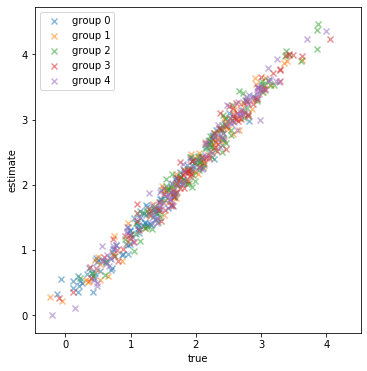

In [52]:
alpha = 0.5

plt.figure(figsize=(8,6))

for i in range(np.max(groups)+1):
    plt.scatter(ranks[groups==i],
                scaled_ranks[groups==i],
                marker='x', alpha=alpha,
                label="group {}".format(i))

plt.axis('square')
plt.ylabel("estimate")
plt.xlabel("true")

plt.legend()

plt.show()

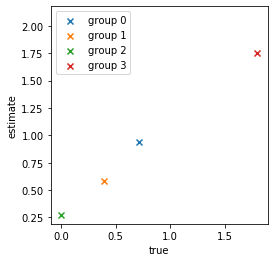

In [12]:
for i in range(np.max(groups)+1):
    plt.scatter(theta[i] - np.min(theta),
                theta_est[i] - np.min(theta),
                marker='x',
                label="group {}".format(i))

plt.axis('square')
plt.ylabel("estimate")
plt.xlabel("true")

plt.legend()

plt.show()

- How to recover $\beta$
- Things that we need to recover ranks
- Things that we need to recover group penalties
- Regularization - Identify correct regularization coefficients
- ~Use a sparse/iterative solver~
- See results for different $k, N$